# tf-embed: 文埋め込みと可視化のデモンストレーション

## 📝 このノートブックの目的

このノートブックでは、**Sentence-Transformers**を使った自然言語処理の基本的なワークフローを実演します。具体的には以下のプロセスを通じて、文章の意味的類似性を視覚的に理解できるようにします。

## 🎯 何を見せるのか

1. **多言語文埋め込み**: 英語と日本語の文章を同じ埋め込み空間にマッピング
2. **意味的類似性の可視化**: 類似した意味を持つ文章が近くに配置されることの確認
3. **次元削減技術**: 高次元の埋め込みベクトルを2次元で可視化する手法（UMAP）
4. **インタラクティブ探索**: TensorBoard Projectorを使った埋め込み空間の詳細な分析

## 🔬 実験内容

- **機械学習関連**の文章（英語・日本語）
- **自然・アウトドア関連**の文章（英語・日本語）

これらの文章群が埋め込み空間でどのようにクラスタリングされるかを観察します。

## 📋 必要な依存関係

```
sentence-transformers>=5.1.0    # 文埋め込みモデル
umap-learn>=0.5.9              # 次元削減
tensorflow>=2.20.0             # TensorBoard Projector用
matplotlib>=3.10.6             # グラフ描画
japanize-matplotlib>=1.1.3     # 日本語フォント対応
numpy>=2.2                     # 数値計算
```

## 🚀 実行方法

**上から順番にセルを実行**するだけで、埋め込みの計算から可視化、TensorBoard用ファイルの生成まで完了します。

最後に生成される `tensorboard --logdir=logs/st_embeddings` コマンドを実行すると、ブラウザでインタラクティブな埋め込み空間を探索できます。

## 🔧 メイン実行パイプライン

以下のセルでは、**一連の処理を通して実行**し、文埋め込みから可視化までの全工程を体験できます。

### 処理フロー:
1. **サンプル文章の準備** - 機械学習と自然に関する英日混合の文章
2. **モデル読み込み** - all-MiniLM-L6-v2（多言語対応の軽量モデル）
3. **埋め込み計算** - 各文章を384次元のベクトルに変換
4. **次元削減** - UMAPで2次元に圧縮（可視化のため）
5. **散布図表示** - 文章間の意味的距離を視覚確認
6. **TensorBoard用保存** - より詳細な分析のためのファイル出力

**期待される結果**: 機械学習関連の文章同士、自然関連の文章同士が近くに配置されることを確認できます。

In [13]:
# 基本インポート（必要なライブラリがインストールされている前提）
import os
from typing import List, Tuple, Optional

import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語ラベル対応（表示環境に依存）

# TensorBoard用の保存にのみ必要
import tensorflow as tf
from tensorboard.plugins import projector

# クラスタリング用
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# 定数
DEFAULT_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"


def get_model(model_name: str = DEFAULT_MODEL_NAME) -> SentenceTransformer:
    """SentenceTransformer モデルをロードして返す。

    model_name: transformers のモデル名 or ローカルパス
    戻り値: SentenceTransformer オブジェクト
    """
    return SentenceTransformer(model_name)


def encode_sentences(
    model: SentenceTransformer,
    sentences: List[str],
    batch_size: int = 64,
    normalize: bool = True,
    show_progress_bar: bool = False,
) -> np.ndarray:
    """文のリストを埋め込みベクトル（NumPy 配列）に変換する。

    - normalize=True にするとコサイン類似度計算がしやすくなる。
    """
    emb = model.encode(
        sentences,
        batch_size=batch_size,
        convert_to_numpy=True,
        normalize_embeddings=normalize,
        show_progress_bar=show_progress_bar,
    )
    return emb


def reduce_dimensionality(
    emb: np.ndarray,
    n_components: int = 2,
    random_state: int = 42,
    n_neighbors: int = 15,
    min_dist: float = 0.1,
) -> np.ndarray:
    """UMAP を使って埋め込みを 2 次元に圧縮して返す。

    パラメータはデフォルト値を指定しているが、必要に応じて変更可能。
    """
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="cosine",
        random_state=random_state,
    )
    emb_2d = reducer.fit_transform(emb)
    return emb_2d


def perform_clustering(
    emb: np.ndarray, 
    method: str = "kmeans", 
    n_clusters: int = 8,
    random_state: int = 42
) -> Tuple[np.ndarray, float]:
    """埋め込みベクトルに対してクラスタリングを実行する。
    
    Args:
        emb: 埋め込みベクトル (N, D)
        method: クラスタリング手法 ("kmeans", "dbscan", "hierarchical")
        n_clusters: クラスター数 (DBSCANでは使用されない)
        random_state: 乱数シード
        
    Returns:
        cluster_labels: クラスターラベル
        silhouette_avg: シルエット係数
    """
    if method == "kmeans":
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    elif method == "dbscan":
        # DBSCANは自動でクラスター数を決定
        clusterer = DBSCAN(eps=0.5, min_samples=3, metric='cosine')
    elif method == "hierarchical":
        clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    else:
        raise ValueError(f"Unknown clustering method: {method}")
    
    cluster_labels = clusterer.fit_predict(emb)
    
    # シルエット係数を計算（クラスター数が1より大きい場合のみ）
    if len(set(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(emb, cluster_labels)
    else:
        silhouette_avg = -1.0
    
    return cluster_labels, silhouette_avg


def plot_embeddings_with_clusters(
    emb_2d: np.ndarray, 
    labels: List[str], 
    cluster_labels: Optional[np.ndarray] = None,
    title: str = "Embeddings (UMAP)",
    show_labels: bool = True,
    figsize: Tuple[int, int] = (12, 8)
) -> None:
    """2次元埋め込みを散布図で表示し、クラスターごとに色分けする。

    Args:
        emb_2d: 2次元に削減された埋め込み
        labels: 各点のラベル（文章）
        cluster_labels: クラスターラベル（Noneの場合は単色表示）
        title: グラフのタイトル
        show_labels: 文章テキストを表示するかどうか
        figsize: 図のサイズ
    """
    plt.style.use("ggplot")
    fig, ax = plt.subplots(figsize=figsize)
    
    if cluster_labels is not None:
        # 実際に存在するクラスターIDを取得
        unique_clusters = sorted(set(cluster_labels))
        n_clusters = len(unique_clusters)
        
        # 十分な色数を確保（最低でも実際のクラスター数分）
        colors = sns.color_palette("tab20", max(n_clusters, 10))
        
        # クラスターIDから色インデックスへのマッピングを作成
        color_map = {cluster_id: i for i, cluster_id in enumerate(unique_clusters)}
        
        for cluster_id in unique_clusters:
            mask = cluster_labels == cluster_id
            color_idx = color_map[cluster_id]
            
            if cluster_id == -1:  # ノイズポイント（DBSCANの場合）
                ax.scatter(emb_2d[mask, 0], emb_2d[mask, 1], 
                          c='black', marker='x', s=50, alpha=0.6, label='Noise')
            else:
                ax.scatter(emb_2d[mask, 0], emb_2d[mask, 1], 
                          c=[colors[color_idx]], s=60, alpha=0.7, 
                          label=f'Cluster {cluster_id}')
        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        # 単色表示
        ax.scatter(emb_2d[:, 0], emb_2d[:, 1], alpha=0.7)
    
    # 文章ラベルを表示（オプション）
    if show_labels:
        for i, s in enumerate(labels):
            # ラベルの位置を少しずらして重なりを軽減
            ax.text(emb_2d[i, 0] + 0.01, emb_2d[i, 1] + 0.01, s, 
                   fontsize=8, alpha=0.8)
    
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def analyze_clusters(
    sentences: List[str], 
    cluster_labels: np.ndarray, 
    emb: np.ndarray,
    top_n: int = 3
) -> None:
    """クラスターの内容を分析し、各クラスターの代表的な文章を表示する。
    
    Args:
        sentences: 文章リスト
        cluster_labels: クラスターラベル
        emb: 元の埋め込みベクトル
        top_n: 各クラスターで表示する代表文章数
    """
    unique_clusters = sorted(set(cluster_labels))
    
    print("📊 クラスター分析結果")
    print("=" * 50)
    
    for cluster_id in unique_clusters:
        if cluster_id == -1:
            print(f"\n🔍 ノイズポイント:")
            mask = cluster_labels == cluster_id
            noise_sentences = [sentences[i] for i in np.where(mask)[0]]
            for i, sent in enumerate(noise_sentences[:top_n]):
                print(f"  • {sent}")
            continue
            
        mask = cluster_labels == cluster_id
        cluster_sentences = [sentences[i] for i in np.where(mask)[0]]
        cluster_embeddings = emb[mask]
        
        # クラスターの中心を計算
        center = np.mean(cluster_embeddings, axis=0)
        
        # 中心に最も近い文章を見つける
        distances = np.linalg.norm(cluster_embeddings - center, axis=1)
        closest_indices = np.argsort(distances)[:top_n]
        
        print(f"\n🎯 クラスター {cluster_id} (文章数: {len(cluster_sentences)})")
        print(f"代表的な文章:")
        for i, idx in enumerate(closest_indices):
            print(f"  {i+1}. {cluster_sentences[idx]}")


def save_for_projector(
    emb: np.ndarray, labels: List[str], log_dir: str
) -> Tuple[str, str]:
    """TensorBoard Projector 用に埋め込みを保存する。

    - emb: (N, D) の NumPy 配列
    - labels: 各埋め込みに対応する文字列ラベル
    - log_dir: 出力ディレクトリ（存在しない場合は作成する）

    戻り値: (ckpt_path, metadata_path)
    """
    os.makedirs(log_dir, exist_ok=True)

    # TensorFlow の Variable に包んでチェックポイントとして保存する必要がある
    emb_var = tf.Variable(emb, name="st_sentence_embeddings")
    ckpt = tf.train.Checkpoint(embedding=emb_var)
    ckpt_path = ckpt.save(os.path.join(log_dir, "embedding.ckpt"))

    # metadata.tsv を作る（1行に1つのラベル）
    meta_path = os.path.join(log_dir, "metadata.tsv")
    with open(meta_path, "w", encoding="utf-8") as f:
        for s in labels:
            f.write(s.replace("\n", " ") + "\n")

    # projector 設定ファイルを作成（TensorBoard 側で読み込むため）
    config = projector.ProjectorConfig()
    e = config.embeddings.add()
    # TensorFlow の内部名（Variable の属性名）に合わせる
    e.tensor_name = "st_sentence_embeddings/.ATTRIBUTES/VARIABLE_VALUE"
    e.metadata_path = "metadata.tsv"
    projector.visualize_embeddings(log_dir, config)

    return ckpt_path, meta_path

In [3]:
# 1) モデルをロード
model = get_model()

In [4]:
with open("corpus.txt", "r", encoding="utf-8") as f:
    sentences = [line.strip() for line in f if line.strip()]

print(f"Loaded {len(sentences)} sentences from corpus.txt")
print("Sample sentences:", sentences[:5])

Loaded 110 sentences from corpus.txt
Sample sentences: ['機械学習はデータ分析の方法を革命的に変えています。', '深層学習モデルは大規模データセットの複雑なパターンを処理できます。', 'ニューラルネットワークは人間の脳の構造にインスパイアされています。', '人工知能は世界中の様々な産業を変革しています。', '自然言語処理により、コンピュータは人間の言語を理解できます。']


In [5]:
# 2) 埋め込みを計算
emb = encode_sentences(model, sentences, batch_size=64, normalize=True, show_progress_bar=True)
print("emb shape:", emb.shape)

Batches: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

emb shape: (110, 384)


In [6]:
# 3) 次元削減（UMAP）
emb_2d = reduce_dimensionality(emb, n_components=2, random_state=42)
print("emb_2d shape:", emb_2d.shape)

/Users/ah000286/mnt/Personal/tf_embed/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


emb_2d shape: (110, 2)


In [14]:
# 4) クラスタリング分析
print("🔍 クラスタリング分析を実行中...")

# 複数のクラスタリング手法を試行
clustering_methods = {
    "K-Means (8クラスター)": ("kmeans", 8),
    "K-Means (10クラスター)": ("kmeans", 10),
    "DBSCAN (自動クラスター数)": ("dbscan", None),
    "階層クラスタリング (8クラスター)": ("hierarchical", 8)
}

clustering_results = {}

for name, (method, n_clusters) in clustering_methods.items():
    if n_clusters:
        cluster_labels, silhouette_avg = perform_clustering(emb, method, n_clusters)
    else:
        cluster_labels, silhouette_avg = perform_clustering(emb, method)
    
    clustering_results[name] = {
        "labels": cluster_labels,
        "silhouette": silhouette_avg,
        "n_clusters": len(set(cluster_labels))
    }
    
    print(f"✅ {name}")
    print(f"   クラスター数: {len(set(cluster_labels))}")
    print(f"   シルエット係数: {silhouette_avg:.3f}")
    print()

# 最も良いシルエット係数を持つ手法を選択
best_method = max(clustering_results.keys(), 
                  key=lambda x: clustering_results[x]["silhouette"])
best_labels = clustering_results[best_method]["labels"]

print(f"🏆 最適なクラスタリング手法: {best_method}")
print(f"   シルエット係数: {clustering_results[best_method]['silhouette']:.3f}")
print(f"   クラスター数: {clustering_results[best_method]['n_clusters']}")

🔍 クラスタリング分析を実行中...
✅ K-Means (8クラスター)
   クラスター数: 8
   シルエット係数: 0.072

✅ K-Means (10クラスター)
   クラスター数: 10
   シルエット係数: 0.065

✅ DBSCAN (自動クラスター数)
   クラスター数: 8
   シルエット係数: 0.009

✅ 階層クラスタリング (8クラスター)
   クラスター数: 8
   シルエット係数: 0.066

🏆 最適なクラスタリング手法: K-Means (8クラスター)
   シルエット係数: 0.072
   クラスター数: 8


🎨 クラスター別可視化を生成中...

📊 基本的な埋め込み可視化:


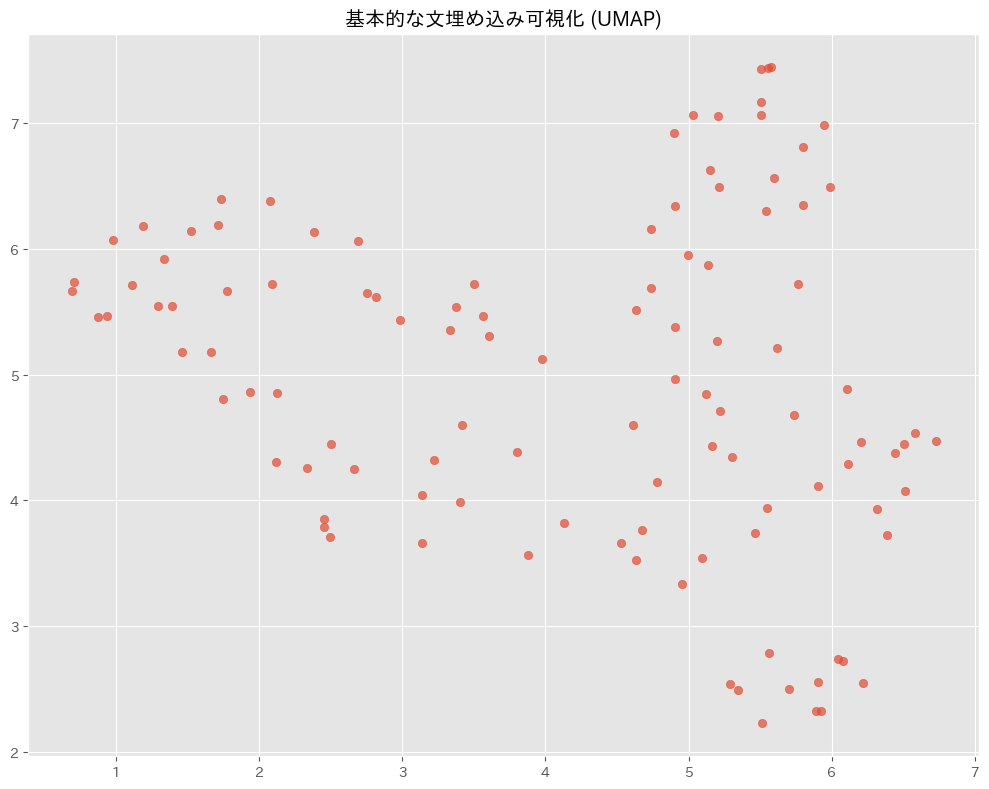


🎯 K-Means (8クラスター)を使用したクラスター別可視化:


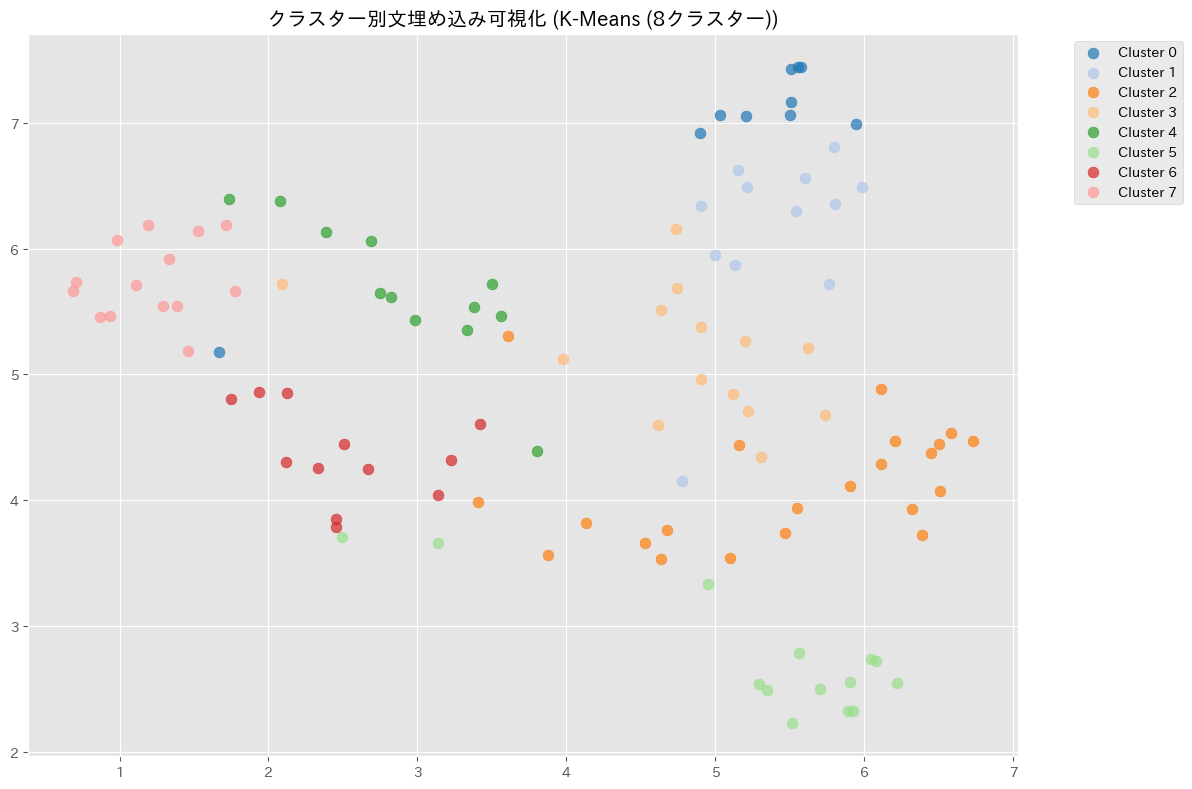


📝 サンプル文章での詳細表示（最初の20文）:


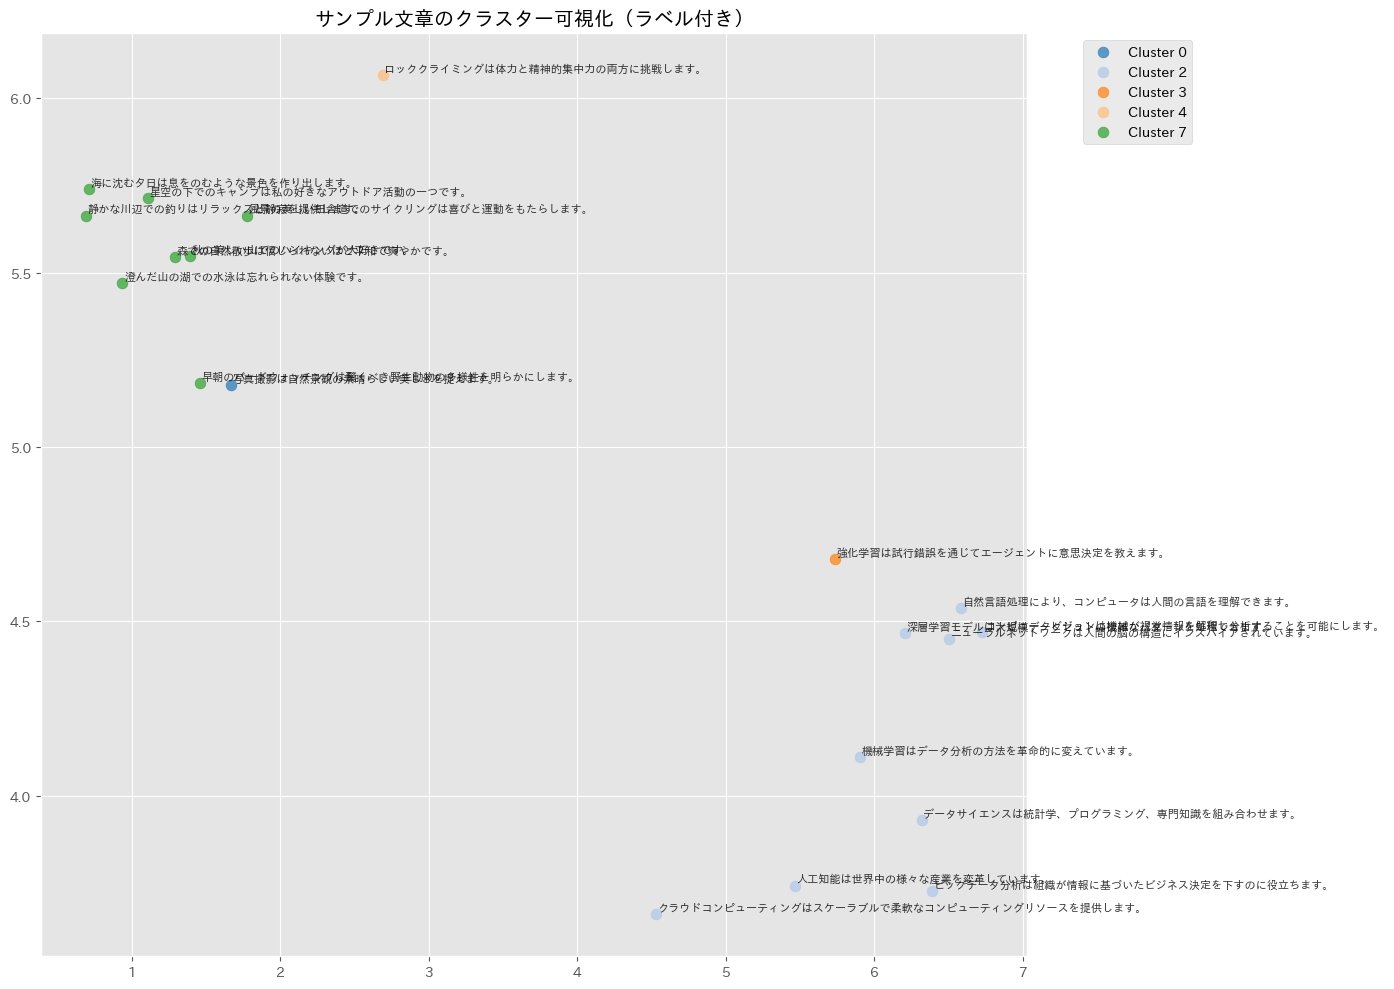

In [16]:
# 5) 可視化（クラスター別色分け）
print("🎨 クラスター別可視化を生成中...")

# クラスターなしの基本プロット
print("\n📊 基本的な埋め込み可視化:")
plot_embeddings_with_clusters(
    emb_2d, sentences, 
    title="基本的な文埋め込み可視化 (UMAP)",
    show_labels=False,  # 100文あるのでラベルは非表示
    figsize=(10, 8)
)

# 最適なクラスタリング結果での可視化
print(f"\n🎯 {best_method}を使用したクラスター別可視化:")
plot_embeddings_with_clusters(
    emb_2d, sentences, 
    cluster_labels=best_labels,
    title=f"クラスター別文埋め込み可視化 ({best_method})",
    show_labels=False,  # 100文あるのでラベルは非表示
    figsize=(12, 8)
)

# 文章数が少ない場合のサンプル表示（最初の20文のみ）
print("\n📝 サンプル文章での詳細表示（最初の20文）:")
sample_indices = np.arange(20)
plot_embeddings_with_clusters(
    emb_2d[sample_indices], 
    [sentences[i] for i in sample_indices],
    cluster_labels=best_labels[sample_indices] if best_labels is not None else None,
    title="サンプル文章のクラスター可視化（ラベル付き）",
    show_labels=True,
    figsize=(14, 10)
)

In [17]:
# 6) クラスター内容の詳細分析
print("🔍 各クラスターの内容分析...")

# 最適なクラスタリング結果を分析
analyze_clusters(sentences, best_labels, emb, top_n=3)

# 全クラスタリング手法の比較表示
print("\n\n📈 全クラスタリング手法の性能比較:")
print("=" * 60)
print(f"{'手法':<30} {'クラスター数':<12} {'シルエット係数':<15}")
print("-" * 60)

for method_name, results in clustering_results.items():
    print(f"{method_name:<30} {results['n_clusters']:<12} {results['silhouette']:<15.3f}")

print("\n💡 シルエット係数の解釈:")
print("  • 0.7-1.0: 強い構造のクラスター")
print("  • 0.5-0.7: 合理的な構造のクラスター") 
print("  • 0.25-0.5: 弱い構造、人工的な可能性")
print("  • < 0.25: クラスター構造なし")

🔍 各クラスターの内容分析...
📊 クラスター分析結果

🎯 クラスター 0 (文章数: 10)
代表的な文章:
  1. 現代芸術運動は伝統的な美的慣習に挑戦しています。
  2. ルネサンス画家は遠近法と写実主義の新しい技法を開発しました。
  3. 建築は異なる文明の価値観と美学を反映しています。

🎯 クラスター 1 (文章数: 12)
代表的な文章:
  1. 文化交流プログラムは異なる社会間の理解を促進します。
  2. 国際的な祭りは多様な音楽、食べ物、伝統を紹介します。
  3. 文化的多様性は多様な視点と経験を通じてコミュニティを豊かにします。

🎯 クラスター 2 (文章数: 22)
代表的な文章:
  1. 機械学習は現代のデータ分析において重要な技術です。
  2. 機械学習はデータ分析の方法を革命的に変えています。
  3. データサイエンスは統計学、プログラミング、専門知識を組み合わせます。

🎯 クラスター 3 (文章数: 14)
代表的な文章:
  1. チームワークは個人の強みを組み合わせて集団の目標を達成します。
  2. キャリア計画は個人が職業的目標を設定し達成するのに役立ちます。
  3. ネットワーキングは価値のある職業的関係と機会を築きます。

🎯 クラスター 4 (文章数: 12)
代表的な文章:
  1. 瞑想とマインドフルネス実践はストレスと不安レベルを軽減します。
  2. 定期的な運動は良好な身体の健康を維持するために重要です。
  3. 健康的なライフスタイルの選択は寿命を大幅に延ばすことができます。

🎯 クラスター 5 (文章数: 14)
代表的な文章:
  1. 暗号通貨市場は高いボラティリティとリスクで知られています。
  2. 株式市場はこの四半期に大きなボラティリティを経験しました。
  3. インフレは時間の経過とともに消費者の購買力に影響します。

🎯 クラスター 6 (文章数: 12)
代表的な文章:
  1. 環境教育は生態系保護への意識を高めます。
  2. 持続可能な農業実践は土壌と水資源の保護に役立ちます。
  3. ガーデニングは人々を自然と結びつけ、新鮮なハーブを提供します。

🎯 クラスター 7 (文章数: 14)
代表的な文章:
  1. 森林浴は心身のリラックスに非常に効

In [18]:
# 7) TensorBoard Projector 用に保存（クラスター情報付き）
log_dir = "logs/st_embeddings"
os.makedirs(log_dir, exist_ok=True)

# 埋め込みを保存
emb_var = tf.Variable(emb, name="st_sentence_embeddings")
ckpt = tf.train.Checkpoint(embedding=emb_var)
ckpt_path = ckpt.save(os.path.join(log_dir, "embedding.ckpt"))

# メタデータ（文章 + クラスター情報）を保存
meta_path = os.path.join(log_dir, "metadata.tsv")
with open(meta_path, "w", encoding="utf-8") as f:
    # ヘッダー行
    f.write("sentence\tcluster\n")
    # データ行
    for i, sentence in enumerate(sentences):
        cluster_id = best_labels[i] if best_labels is not None else 0
        clean_sentence = sentence.replace("\n", " ").replace("\t", " ")
        f.write(f"{clean_sentence}\t{cluster_id}\n")

# projector 設定ファイルを作成
config = projector.ProjectorConfig()
e = config.embeddings.add()
e.tensor_name = "st_sentence_embeddings/.ATTRIBUTES/VARIABLE_VALUE"
e.metadata_path = "metadata.tsv"
projector.visualize_embeddings(log_dir, config)

print(f"✅ 保存完了:")
print(f"   チェックポイント: {ckpt_path}")
print(f"   メタデータ: {meta_path}")
print(f"   クラスター情報: {len(set(best_labels))}個のクラスター")
print("\n🚀 TensorBoard起動コマンド:")
print("   tensorboard --logdir=logs/st_embeddings")
print("\n💡 TensorBoard Projectorでの操作:")
print("   • 左パネル: 'Color by' で 'cluster' を選択してクラスター別色分け")
print("   • 右パネル: 点をクリックして近傍文章を確認")
print("   • 検索: 特定の文章やクラスターを検索可能")

✅ 保存完了:
   チェックポイント: logs/st_embeddings/embedding.ckpt-1
   メタデータ: logs/st_embeddings/metadata.tsv
   クラスター情報: 8個のクラスター

🚀 TensorBoard起動コマンド:
   tensorboard --logdir=logs/st_embeddings

💡 TensorBoard Projectorでの操作:
   • 左パネル: 'Color by' で 'cluster' を選択してクラスター別色分け
   • 右パネル: 点をクリックして近傍文章を確認
   • 検索: 特定の文章やクラスターを検索可能


## 📊 結果の解釈と詳細分析

### 🎯 クラスタリング結果の観察ポイント

上記の実行により、以下の3つの可視化が生成されました：

#### 1. **基本的な埋め込み可視化**
- 全100文の分布を単色で表示
- 文章間の大まかな距離関係を確認
- 意味的に近い文章が物理的に近くに配置されているかを観察

#### 2. **クラスター別色分け可視化**
- 自動選択された最適なクラスタリング手法による色分け
- 各色が異なるトピック/テーマを表現
- クラスター境界の明確さとクラスター内の結束度を確認

#### 3. **サンプル詳細表示（最初の20文）**
- 文章テキスト付きでクラスターの内容を詳細確認
- どのような文章が同じクラスターに分類されたかを検証

### 🔍 観察すべき意味的クラスタリングパターン

#### **期待される主要クラスター**
- 🤖 **技術・AI系**: 機械学習、深層学習、データサイエンス、クラウド技術
- 🌲 **自然・アウトドア系**: ハイキング、自然体験、森林浴、山登り
- 💰 **金融・経済系**: 株式市場、投資、経済指標、暗号通貨
- 🎨 **文化・芸術系**: 音楽、美術、文学、シェイクスピア
- 🏥 **健康・医療系**: 運動、食事、メンタルヘルス、医療研究
- 🌍 **環境・持続可能性系**: 気候変動、再生可能エネルギー、リサイクル
- 💼 **キャリア・ビジネス系**: 専門開発、リーダーシップ、チームワーク
- 🏠 **日常生活系**: コーヒー、料理、読書、ガーデニング

#### **クラスタリング品質の評価指標**
- **シルエット係数**: 0.3以上なら合理的、0.5以上なら良好な構造
- **クラスター内結束度**: 同じ色の点が密集しているか
- **クラスター間分離度**: 異なる色のクラスターが明確に分かれているか

### 🔬 自動クラスタリング分析の読み方

#### **クラスタリング手法比較**
実行結果で表示される4つの手法の特徴：

| 手法 | 特徴 | 適用場面 |
|------|------|----------|
| **K-Means** | 球状クラスターを形成、事前にクラスター数を指定 | バランスの取れた分割が欲しい場合 |
| **DBSCAN** | 密度ベース、ノイズ検出可能、クラスター数自動決定 | 不規則な形状のクラスターがある場合 |
| **階層クラスタリング** | 樹形図構造、段階的なクラスター形成 | クラスター間の階層関係を知りたい場合 |

#### **クラスター内容分析の活用**
各クラスターの代表文章から以下を確認：
- **意味的一貫性**: 同じクラスター内の文章が類似トピックか
- **誤分類の検出**: 明らかに異なるトピックが混在していないか
- **クラスターの解釈**: そのクラスターが何を表現しているか

### 🎨 可視化の詳細解釈

#### **色分けの意味**
- **同じ色の点**: 意味的に類似した文章群
- **色の境界**: トピック間の意味的境界
- **孤立した点**: 他とは異なる独特な内容の文章
- **重複領域**: 複数トピックにまたがる内容

#### **空間配置の解釈**
- **距離の近さ**: コサイン類似度の高さを反映
- **クラスター密度**: そのトピックの内容の一貫性
- **外れ値**: 特殊な表現や珍しい組み合わせの文章

### 🔍 TensorBoard Projectorでの高度な分析

生成されたファイルを使って、ブラウザでインタラクティブな探索が可能：

```bash
tensorboard --logdir=logs/st_embeddings
```

#### **Projectorの活用法**

| 機能 | 操作 | 得られる情報 |
|------|------|-------------|
| **Color by cluster** | 左パネルで'cluster'を選択 | クラスター別色分け表示 |
| **近傍検索** | 点をクリック | 最も類似した文章10件を表示 |
| **検索機能** | 右上の検索ボックス | 特定キーワードを含む文章をハイライト |
| **3D表示** | '3D'ボタンをクリック | より詳細な空間構造を確認 |
| **次元削減比較** | PCA/t-SNE/UMAPを切り替え | 異なる手法での可視化比較 |

### 🧪 発展的な分析手法

#### **追加実験のアイデア**
```python
# 1. 異なるモデルでの比較
models_to_compare = [
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "sentence-transformers/all-MiniLM-L6-v2", 
    "sentence-transformers/distiluse-base-multilingual-cased"
]

# 2. クラスター数の最適化
from sklearn.metrics import calinski_harabasz_score
for k in range(5, 15):
    labels, _ = perform_clustering(emb, "kmeans", k)
    score = calinski_harabasz_score(emb, labels)
    print(f"K={k}: Calinski-Harabasz Score = {score:.2f}")

# 3. 類似文章検索システム
def semantic_search(query, top_k=5):
    query_emb = model.encode([query])
    similarities = np.dot(emb, query_emb.T).flatten()
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    return [(sentences[i], similarities[i]) for i in top_indices]

# 使用例
results = semantic_search("人工知能について学びたい")
```

### 🎯 結果の品質評価チェックリスト

#### **良好なクラスタリングの指標**
- ✅ シルエット係数が0.3以上
- ✅ 同じトピックの文章が同じクラスターに集約
- ✅ 異なるトピック間で明確な分離
- ✅ ノイズや外れ値が適切に識別

#### **改善が必要な場合の対処法**
- **クラスターが混在**: UMAPパラメータ調整(`n_neighbors`, `min_dist`)
- **分離が不十分**: 異なるクラスタリング手法を試行
- **クラスター数が不適切**: K-Meansの`n_clusters`を調整
- **モデル性能不足**: より高性能なSentence-Transformersモデルを使用

この分析により、日本語文埋め込みの意味的構造と、自動クラスタリングの有効性を定量的・視覚的に評価できます。